In [1]:
from os import path
import os
import glob
import warnings

import astropy.coordinates as coord
from astropy.table import Table, hstack, join
import astropy.units as u
from astropy.io import ascii
from astropy.io import fits
import reproject

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
from scipy.spatial import cKDTree

from pyia import GaiaData
import gala.coordinates as gc
from dustmaps.sfd import SFDQuery
from astroquery.gaia import Gaia

from sfd import reddening
Gaia.login(user='apricewh', password='7Gy2^otQNj6FKz6')

/Users/adrian/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
data_path = '../data/xmatch/'
if not path.exists(data_path):
    os.makedirs(data_path)

Width and height of polygon to select:

In [ ]:
w = 8*u.deg
h = 4*u.deg

Corners of spherical polygonal to select:

In [3]:
cluster_c = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg)
cl_mag = cluster_c.transform_to(gc.MagellanicStream)

cl_mag.L.degree-4.
corners_c = gc.MagellanicStream

<SkyCoord (MagellanicStream): (L, B) in deg
    (64.27102056, -12.4971508)>

In [3]:
corners_c = coord.SkyCoord(ra=179*u.deg, dec=-29*u.deg)

In [4]:
field_radius = coord.Angle(3*u.deg)

## First look at Isochrones to help color selection

In [5]:
dup_cols = ['EEP', 'isochrone_age_yr',
'initial_mass',
'star_mass',
'log_Teff',
'log_g',
'log_L',
'[Fe/H]_init',
'[Fe/H]',
'phase']

In [12]:
# alltbl = None
# for fn in glob.glob('../data/old/-0.5/MIST*'):
#     tbl = Table.read(fn, header_start=12, format='ascii')
#     if alltbl is None:
#         alltbl = tbl
#     else:
#         for col in dup_cols:
#             tbl.remove_column(col)
#         alltbl = hstack((alltbl, tbl))
# alltbl.write('../data/FeH-0.5_all.fits', overwrite=True)

In [6]:
iso = Table.read('../data/FeH-1_all.fits')
DM = coord.Distance(25*u.kpc).distmod.value

## Gaia DR2 alone:

(21, 10)

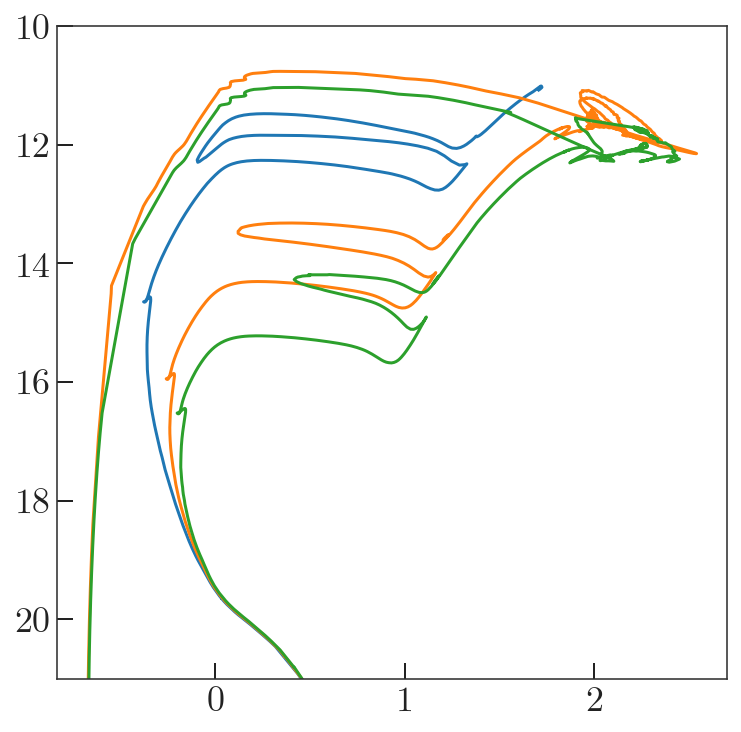

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for age in np.unique(iso['isochrone_age_yr'])[::2]:
    i = iso[iso['isochrone_age_yr'] == age]
    ax.plot(i['Gaia_BP_DR2Rev']-i['Gaia_RP_DR2Rev'],
            i['Gaia_G_DR2Rev'] + DM, marker='')

ax.set_ylim(21, 10)

In [87]:
q_fmt ='''SELECT *
FROM gaiadr2.gaia_source
WHERE parallax < 1 AND 
    CONTAINS(POINT('ICRS', ra, dec), 
             CIRCLE('ICRS', {0.ra.degree}, {0.dec.degree}, {1.degree})) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'''
q = q_fmt.format(cluster_c, field_radius)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q)

Launched query: 'SELECT *
FROM gaiadr2.gaia_source
WHERE parallax < 1 AND 
    CONTAINS(POINT('ICRS', ra, dec), 
             CIRCLE('ICRS', 179.0, -29.0, 3.0)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'
Retrieving async. results...
Query finished.


In [88]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
tbl.write('../data/gaiadr2.fits', overwrite=True)

(21, 8)

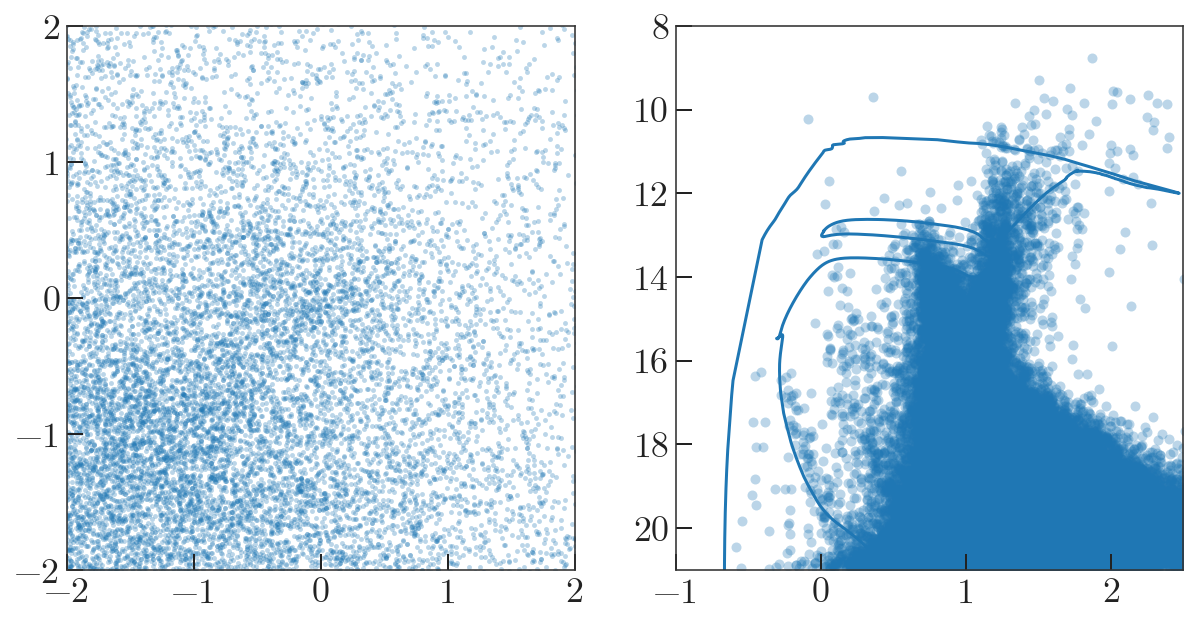

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.scatter(tbl['pmra'], tbl['pmdec'], alpha=0.3, s=6, linewidth=0)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

ax = axes[1]
ax.scatter(tbl['phot_bp_mean_mag']-tbl['phot_rp_mean_mag'], 
           tbl['phot_g_mean_mag'], alpha=0.3, linewidth=0)

i = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
ax.plot(i['Gaia_BP_DR2Rev']-i['Gaia_RP_DR2Rev'],
        i['Gaia_G_DR2Rev'] + DM, marker='')
    
ax.set_xlim(-1, 2.5)
ax.set_ylim(21, 8)

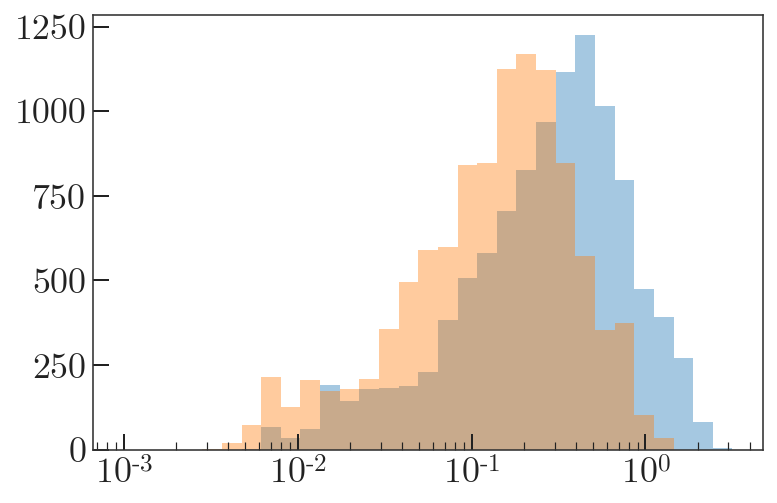

In [93]:
_, bins, _ = plt.hist(tbl[np.isfinite(tbl['a_g_val'])]['a_g_val'], 
                      bins=np.logspace(-3, 0.5, 32), alpha=0.4);
plt.hist(tbl[np.isfinite(tbl['e_bp_min_rp_val'])]['e_bp_min_rp_val'], 
         bins=bins, alpha=0.4);
plt.xscale('log')

## Pan-STARRS:

In [113]:
q_fmt ='''SELECT gaia.source_id, ps1.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', {0.ra.degree}, {0.dec.degree}, {1.degree})) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'''
q = q_fmt.format(cluster_c, field_radius)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q)

Launched query: 'SELECT gaia.source_id, ps1.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.panstarrs1_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr2.panstarrs1_original_valid AS ps1
    ON ps1.obj_id = xmatch.original_ext_source_id
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', 179.0, -29.0, 3.0)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'
Retrieving async. results...
Query finished.


In [115]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
tbl.write('../data/gaia-ps1.fits', overwrite=True)

ERROR! Session/line number was not unique in database. History logging moved to new session 6484


(21, 8)

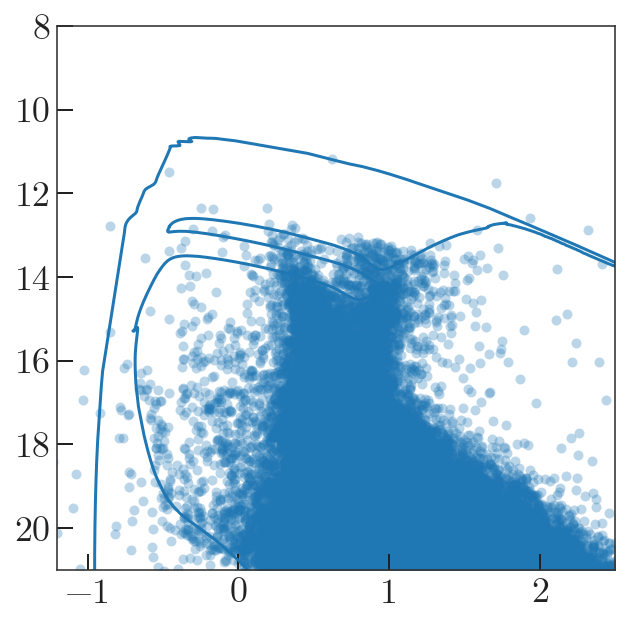

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(tbl['g_mean_psf_mag']-tbl['i_mean_psf_mag'], 
           tbl['g_mean_psf_mag'], alpha=0.3, linewidth=0)

i = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
ax.plot(i['PS_g']-i['PS_i'],
        i['PS_g'] + DM, marker='')
    
ax.set_xlim(-1.2, 2.5)
ax.set_ylim(21, 8)

## Allwise:

In [121]:
q_fmt ='''SELECT gaia.source_id, wise.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.allwise_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.allwise_original_valid AS wise
    ON wise.allwise_oid = xmatch.allwise_oid
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', {0.ra.degree}, {0.dec.degree}, {1.degree})) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'''
q = q_fmt.format(cluster_c, field_radius)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q)

Launched query: 'SELECT gaia.source_id, wise.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.allwise_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.allwise_original_valid AS wise
    ON wise.allwise_oid = xmatch.allwise_oid
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', 179.0, -29.0, 3.0)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'
Retrieving async. results...
Query finished.


In [160]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
        
    tbl[c].unit = None
    
    tbl[c] = np.array(tbl[c])
tbl.meta = dict()

tbl.write('../data/gaia-allwise.fits', overwrite=True)

## 2MASS:

In [164]:
q_fmt ='''SELECT gaia.source_id, tmass.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.tmass_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.tmass_original_valid AS tmass
    ON tmass.tmass_oid = xmatch.tmass_oid
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', {0.ra.degree}, {0.dec.degree}, {1.degree})) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'''
q = q_fmt.format(cluster_c, field_radius)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    job = Gaia.launch_job_async(q)

Launched query: 'SELECT gaia.source_id, tmass.*
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.tmass_best_neighbour AS xmatch
    ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.tmass_original_valid AS tmass
    ON tmass.tmass_oid = xmatch.tmass_oid
WHERE gaia.parallax < 1 AND 
    CONTAINS(POINT('ICRS', gaia.ra, gaia.dec), 
             CIRCLE('ICRS', 179.0, -29.0, 3.0)) = 1 AND
    (pmra > -10) AND (pmra < 10) AND 
    (pmdec > -10) AND (pmdec < 10) 
'
Retrieving async. results...
Query finished.


In [165]:
tbl = job.get_results()

for c in tbl.colnames:
    if tbl[c].dtype == object:
        tbl[c] = np.array(tbl[c]).astype(str)
        
    tbl[c].unit = None
    
    tbl[c] = np.array(tbl[c])
tbl.meta = dict()

tbl.write('../data/gaia-2mass.fits', overwrite=True)

(17, 5)

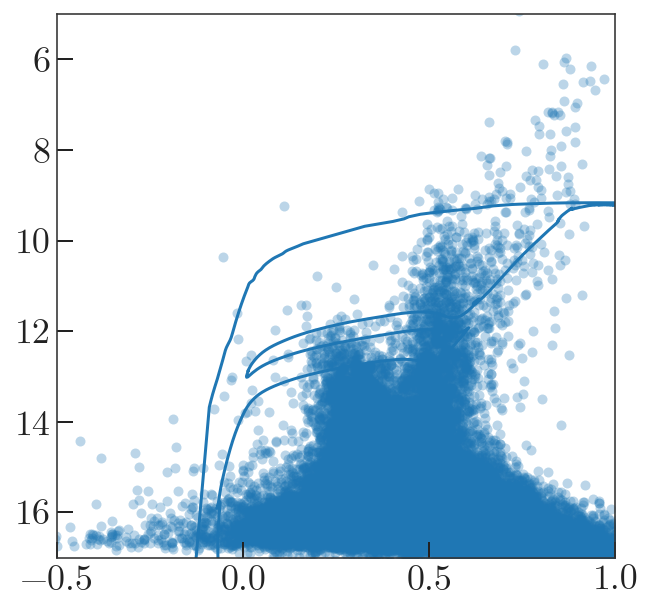

In [170]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(tbl['j_m']-tbl['h_m'], 
           tbl['j_m'], alpha=0.3, linewidth=0)

i = iso[np.isclose(iso['isochrone_age_yr'], 1e8)]
ax.plot(i['2MASS_J']-i['2MASS_H'],
        i['2MASS_J'] + DM, marker='')
    
ax.set_xlim(-0.5, 1)
ax.set_ylim(17, 5)

## Galex:

Manually downloaded 3 deg radius around (179, -29) here: http://vizier.u-strasbg.fr/viz-bin/VizieR-3

Crossmatch with Gaia, manually

In [19]:
gaia = Table.read('../data/gaiadr2.fits')

In [16]:
galex = Table.read('../data/galex.fits')

In [22]:
gaia_c = coord.SkyCoord(ra=gaia['ra'], dec=gaia['dec'])
galex_c = coord.SkyCoord(ra=galex['RAJ2000'], dec=galex['DEJ2000'])

In [23]:
idx, sep, _ = galex_c.match_to_catalog_sky(gaia_c)

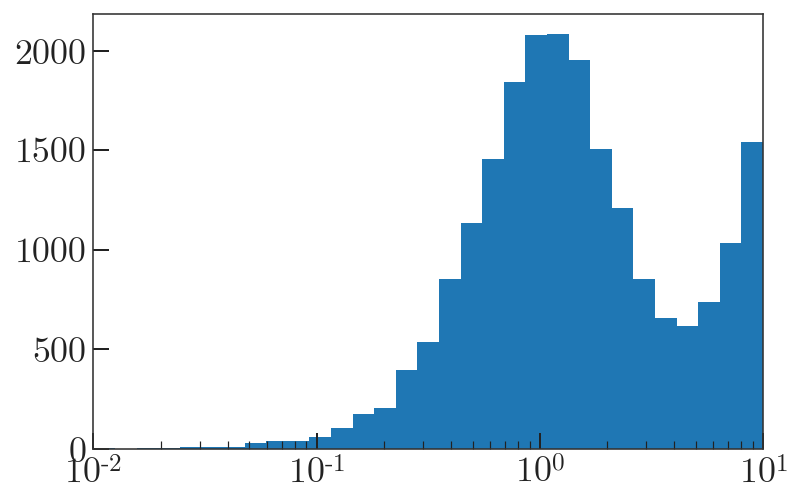

In [26]:
plt.hist(sep.arcsecond, bins=np.logspace(-2, 1, 32));
plt.xlim(1e-2, 10)
plt.xscale('log')

In [27]:
galex_xmatch = galex[sep < 4*u.arcsec].copy()
galex_xmatch['source_id'] = gaia[idx[sep < 4*u.arcsec]]['source_id']

In [28]:
galex_xmatch.write('../data/gaia-galex.fits')

---

## Join All The Things!

In [31]:
gaia = Table.read('../data/gaiadr2.fits')

In [44]:
all_tbl = gaia.copy()
for fn in glob.glob('../data/gaia-*.fits'):
    tbl_name = path.splitext(path.basename(fn))[0].split('-')[1]
    tbl = Table.read(fn)

    for c in tbl.colnames:
        if c == 'source_id': 
            continue

        tbl.rename_column(c, '{0}_{1}'.format(tbl_name, c))
        
    all_tbl = join(all_tbl, tbl, keys='source_id', join_type='left')

In [ ]:
for c in all_tbl.colnames
    all_tbl[c] = np.array(all_tbl[c])

In [46]:
all_tbl.write('../data/all-data-3deg.fits')